In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [479]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,489044,1729,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
1,489045,1729,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
2,489047,1729,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,12,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
3,489048,1729,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,489049,1729,2008-08-16 00:00:00,8559,Bolton Wanderers,10194,Stoke City,3,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0


In [502]:
def transform_target(X, y, class_labels = ['W', 'D', 'L'], weight = True, down_sample = True):
    if weight and down_sample:
        size = np.min(np.unique(pd.concat([y[y == x] for x in class_labels]), return_counts = True)[1])
        idx = [np.random.choice(y[y == x].index.values, size = size) for x in class_labels]
        down_idx = np.concatenate(idx)
        weights = {}
        for class_ in class_labels:
            weights[class_] = y[y == class_].shape[0]/size

        return X.iloc[down_idx], y[down_idx], weights
    elif weight and not down_sample:
        size = np.max(np.unique(pd.concat([y[y == x] for x in class_labels]), return_counts = True)[1])
        weights = {}
        for i, class_ in enumerate(class_labels):
            weights[class_] = size/y[y == class_].shape[0]
        return X, y, weights
    else:
        y_ = pd.concat([y[y == x] for x in class_labels])
        return X.iloc[y_.index], y_, None

def RFpipe(weights = None, params = {}):
    return Pipeline(steps = [
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(class_weight = weights, **params))
    ])

def RFinterpipe(weights = None, params = {}):
    return Pipeline(steps = [
        ('scaler', StandardScaler()),
        ('inter', PolynomialFeatures(2, interaction_only = True, include_bias = False)),
        ('rf', RandomForestClassifier(class_weight = weights, **params))
    ])

def Logitpipe(weights = None, params = {}):
    return Pipeline(steps = [
        ('scaler', StandardScaler()),
        ('logit', LogisticRegression(class_weight = weights, **params))
    ])

def train_test(func, X, y, weight, down_sample, class_labels = ['W', 'D', 'L'], cm = False, seed = None, return_clf = False):
    if seed != None:
        np.random.seed(seed)
    X_ds, y_ds, weights = transform_target(X, y, class_labels = class_labels, weight = weight, down_sample = down_sample)
    X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)

    print('>>>Preprocess done', weights)

    clf = func(weights = weights).fit(X_train, y_train)
    print(metric_suite(clf, X_train, y_train, labels = class_labels, cm = cm))
    print(metric_suite(clf, X_test, y_test, labels = class_labels, cm = cm))
    
    if return_clf:
        return clf

In [564]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

'''Xp = X.filter(regex = 'card_color').copy()
Xp['home_fouls'] = X.filter(regex = 'home_team_foul').sum(axis = 1)
Xp['away_fouls'] = X.filter(regex = 'away_team_foul').sum(axis = 1)
X = Xp
X.shape'''

"Xp = X.filter(regex = 'card_color').copy()\nXp['home_fouls'] = X.filter(regex = 'home_team_foul').sum(axis = 1)\nXp['away_fouls'] = X.filter(regex = 'away_team_foul').sum(axis = 1)\nX = Xp\nX.shape"

### Random Forest

In [456]:
train_test(RFpipe, X, y, weight = False, down_sample = False, cm = False)

>>>Preprocess done None
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.995495   0.989552  0.995495  0.992515      666
1      D  0.972868   0.996032  0.972868  0.984314      258
2      L  0.998544   0.997093  0.998544  0.997818     1374
3  Total  0.994778   0.994788  0.994778  0.994765     2298
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.269461   0.592105  0.269461  0.370370      167
1      D  0.015385   0.142857  0.015385  0.027778       65
2      L  0.924198   0.644309  0.924198  0.759281      343
3  Total  0.631304   0.572461  0.631304  0.563636      575


In [457]:
train_test(RFpipe, X, y, weight = True, down_sample = False, cm = False)

>>>Preprocess done {'W': 2.061224489795918, 'D': 5.315789473684211, 'L': 1.0}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.992492   0.986567  0.992492  0.989521      666
1      D  0.988372   0.984556  0.988372  0.986460      258
2      L  0.994905   0.998539  0.994905  0.996719     1374
3  Total  0.993473   0.993500  0.993473  0.993481     2298
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.263473   0.478261  0.263473  0.339768      167
1      D  0.046154   0.333333  0.046154  0.081081       65
2      L  0.889213   0.643460  0.889213  0.746634      343
3  Total  0.612174   0.560423  0.612174  0.553230      575


In [458]:
train_test(RFpipe, X, y, weight = True, down_sample = True, cm = False)

>>>Preprocess done {'W': 2.5789473684210527, 'D': 1.0, 'L': 5.315789473684211}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  1.000000   0.996139  1.000000  0.998066      258
1      D  0.988417   0.996109  0.988417  0.992248      259
2      L  0.996124   0.992278  0.996124  0.994197      258
3  Total  0.994839   0.994844  0.994839  0.994834      775
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.492308   0.542373  0.492308  0.516129       65
1      D  0.593750   0.703704  0.593750  0.644068       64
2      L  0.661538   0.530864  0.661538  0.589041       65
3  Total  0.582474   0.591739  0.582474  0.582765      194


In [459]:
train_test(RFpipe, X, y, weight = False, down_sample = False, class_labels = ['W', 'L'], cm = False)

>>>Preprocess done None
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.995495   0.994003  0.995495  0.994749      666
1      L  0.997089   0.997815  0.997089  0.997452     1374
2  Total  0.996569   0.996570  0.996569  0.996569     2040
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.269461   0.600000  0.269461  0.371901      167
1      L  0.912536   0.719540  0.912536  0.804627      343
2  Total  0.701961   0.680397  0.701961  0.662931      510


In [460]:
train_test(RFpipe, X, y, weight = True, down_sample = False, class_labels = ['W', 'L'], cm = False)

>>>Preprocess done {'W': 2.061224489795918, 'L': 1.0}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.996997   0.989568  0.996997  0.993269      666
1      L  0.997089   0.996364  0.997089  0.996726     1374
2  Total  0.994343   0.994145  0.997059  0.995597     2040
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.299401   0.500000  0.299401  0.374532      167
1      L  0.883382   0.648822  0.883382  0.748148      343
2  Total  0.613913   0.600090  0.692157  0.625807      510


In [469]:
train_test(RFpipe, X, y, weight = True, down_sample = True, class_labels = ['W', 'L'], cm = False)

>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.995495   0.994003  0.995495  0.994749      666
1      L  0.993994   0.995489  0.993994  0.994741      666
2  Total  0.994745   0.994746  0.994745  0.994745     1332
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.826347   0.802326  0.826347  0.814159      167
1      L  0.796407   0.820988  0.796407  0.808511      167
2  Total  0.811377   0.811657  0.811377  0.811335      334


>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}


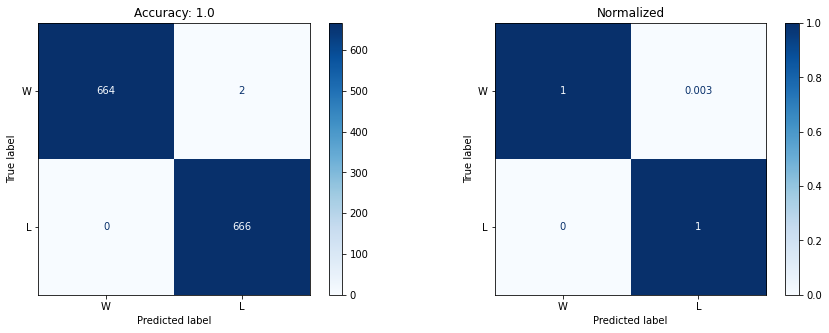

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.996997   1.000000  0.996997  0.998496      666
1      L  1.000000   0.997006  1.000000  0.998501      666
2  Total  0.998498   0.998503  0.998498  0.998498     1332


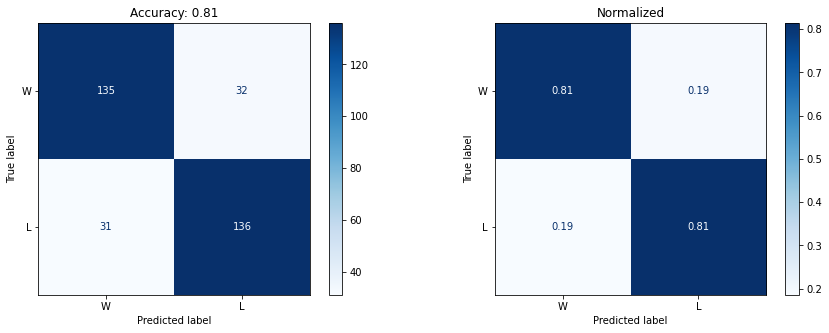

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.808383   0.813253  0.808383  0.810811      167
1      L  0.814371   0.809524  0.814371  0.811940      167
2  Total  0.811377   0.811388  0.811377  0.811376      334


In [397]:
train_test(RFpipe, X, y, weight = True, down_sample = True, class_labels = ['W', 'L'], cm = True, seed = 144)

In [590]:
grid = {
    'rf__max_depth' : list(range(10, 90, 20)) + [None],
    'rf__min_samples_leaf' : [2, 5, 10],
    'rf__min_samples_split' : [2, 5, 10],
    'rf__class_weight' : [weights]
}

cv = GridSearchCV(RFpipe(weights), grid, cv = 10, return_train_score  = True, n_jobs = -1).fit(X_ds, y_ds)
cv_res = pd.DataFrame(cv.cv_results_)

In [309]:
val = [RFpipe(weights).set_params(**param).fit(X_train, y_train).score(X_test, y_test) for param in tqdm(cv_res['params'])]

  0%|          | 0/45 [00:00<?, ?it/s]

In [591]:
cv.best_score_

0.7826671957290239

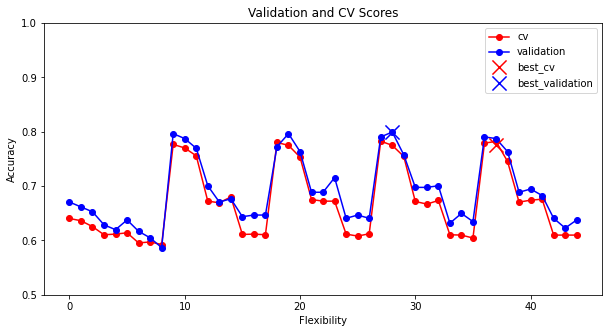

In [594]:
fig, axs = plt.subplots(figsize = (10,5))
plt.plot(cv_res['mean_test_score'], '-o', zorder = 0, color = 'red')
plt.plot(val, '-o', zorder = 1, color = 'blue')
plt.scatter(37,0.776, marker = 'x', s = 200, c = 'r', zorder = 2)
plt.scatter(28,0.7994, marker = 'x', s = 200, c = 'b', zorder = 3)

plt.legend(labels = ['cv', 'validation', 'best_cv', 'best_validation'])
plt.ylim([0.5, 1])
plt.title('Validation and CV Scores')
plt.xlabel('Flexibility')
plt.ylabel('Accuracy')
plt.savefig('CV_valid.png', dpi = 200)
plt.show()

### Logistic Regression

In [428]:
train_test(Logitpipe, X, y, weight = False, down_sample = False, cm = False)
train_test(Logitpipe, X, y, weight = True, down_sample = False, cm = False)
train_test(Logitpipe, X, y, weight = True, down_sample = True, cm = False)

>>>Preprocess done None
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.385886   0.517103  0.385886  0.441960      666
1      D  0.000000   0.000000  0.000000  0.000000      258
2      L  0.874818   0.667407  0.874818  0.757165     1374
3  Total  0.634900   0.548915  0.634900  0.580805     2298
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.425150   0.486301  0.425150  0.453674      167
1      D  0.000000   0.000000  0.000000  0.000000       65
2      L  0.825073   0.659674  0.825073  0.733161      343
3  Total  0.615652   0.534749  0.615652  0.569109      575
>>>Preprocess done {'W': 2.061224489795918, 'D': 5.315789473684211, 'L': 1.0}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.557057   0.444311  0.557057  0.494337      666
1      D  0.465116   0.176730  0.465116  0.256137      258
2      L  0.451237   0.790816  0.451237  0.574606     1374
3  Total  0.483464   0.621449  0.483464  0.515588     2298
   Class  Acc

In [427]:
train_test(Logitpipe, X, y, weight = False, down_sample = False, class_labels = ['W', 'L'], cm = False)
train_test(Logitpipe, X, y, weight = True, down_sample = False, class_labels = ['W', 'L'], cm = False)
train_test(Logitpipe, X, y, weight = True, down_sample = True, class_labels = ['W', 'L'], cm = False)

>>>Preprocess done None
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.367868   0.610973  0.367868  0.459231      666
1      L  0.886463   0.743136  0.886463  0.808497     1374
2  Total  0.717157   0.699989  0.717157  0.694472     2040
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.323353   0.574468  0.323353  0.413793      167
1      L  0.883382   0.728365  0.883382  0.798419      343
2  Total  0.700000   0.677972  0.700000  0.672473      510
>>>Preprocess done {'W': 2.061224489795918, 'L': 1.0}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.762763   0.412338  0.762763  0.535300      666
1      L  0.588064   0.760113  0.588064  0.663110     1374
2  Total  0.572672   0.646575  0.645098  0.621384     2040
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.694611   0.395904  0.694611  0.504348      167
1      L  0.597668   0.726950  0.597668  0.656000      343
2  Total  0.558261   0.618549  0.6294

## Analysis

In [586]:
np.argmin([tree.tree_.max_depth for tree in clf['rf'].estimators_])

65

In [587]:
clf['rf'].estimators_[65].tree_.max_depth

27

>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.996997   1.000000  0.996997  0.998496      666
1      L  1.000000   0.997006  1.000000  0.998501      666
2  Total  0.998498   0.998503  0.998498  0.998498     1332
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.808383   0.813253  0.808383  0.810811      167
1      L  0.814371   0.809524  0.814371  0.811940      167
2  Total  0.811377   0.811388  0.811377  0.811376      334
home_team_card_color_y		0.038 +/- 0.017
home_team_foul_reason_pushing		0.028 +/- 0.013
home_team_foul_reason_penalty		0.024 +/- 0.007


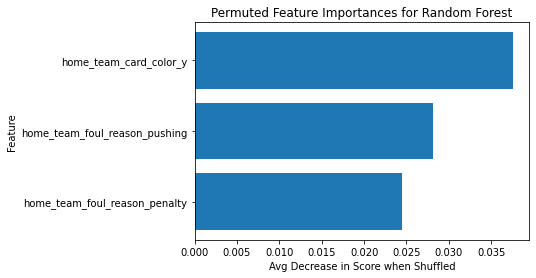

In [579]:
clf = train_test(RFpipe, X, y, weight = True, down_sample = True, class_labels = ['W', 'L'], cm = False, seed = 144, return_clf = True)
X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W','L'], weight = True, down_sample = True)
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)
r = permutation_importance(clf, X_test, y_test, n_repeats = 30)

qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = X.columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

plt.barh(X.columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1])
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg Decrease in Score when Shuffled')
plt.ylabel('Feature')
plt.show()

In [421]:
tree = clf['rf'].estimators_[0].tree_

In [424]:
tree.max_depth

44

In [451]:
X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W','L'], weight = True, down_sample = True)
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)
r = permutation_importance(clf, X_test, y_test, n_repeats = 30)

In [452]:
qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = X.columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

home_team_card_color_y		0.135 +/- 0.02
home_fouls		0.109 +/- 0.024
away_team_card_color_y		0.087 +/- 0.023
away_fouls		0.082 +/- 0.023
away_team_card_color_r		0.031 +/- 0.007


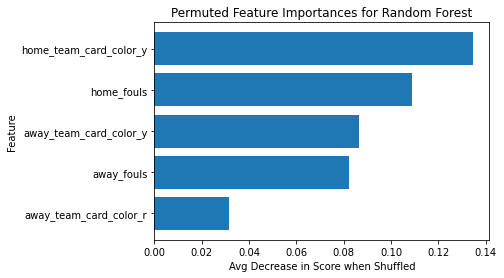

In [453]:
plt.barh(X.columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1])
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg Decrease in Score when Shuffled')
plt.ylabel('Feature')
plt.show()

In [470]:
clf = train_test(RFpipe, X, y, weight = True, down_sample = True, class_labels = ['W', 'L'], cm = False, return_clf = True)
X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W','L'], weight = True, down_sample = True)
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)
r = permutation_importance(clf, X_test, y_test, n_repeats = 30)
qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = X.columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.998498   0.995509  0.998498  0.997001      666
1      L  0.995495   0.998494  0.995495  0.996992      666
2  Total  0.996997   0.997001  0.996997  0.996997     1332
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.778443   0.838710  0.778443  0.807453      167
1      L  0.850299   0.793296  0.850299  0.820809      167
2  Total  0.814371   0.816003  0.814371  0.814131      334
home_team_card_color_y		0.048 +/- 0.016
home_team_foul_reason_penalty		0.017 +/- 0.007
away_team_card_reason_stall_time		0.005 +/- 0.002


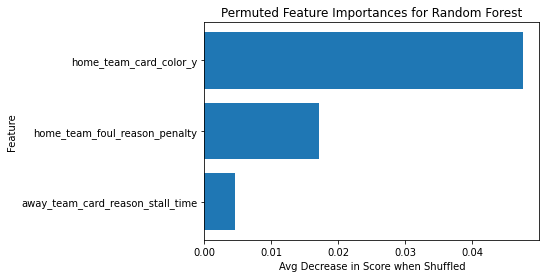

In [471]:
plt.barh(X.columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1])
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg Decrease in Score when Shuffled')
plt.ylabel('Feature')
plt.show()

In [532]:
# Not including every single feature column, polynomial features (interaction)
clf = train_test(RFinterpipe, X, y, weight = True, down_sample = True, class_labels = ['W', 'L'], cm = False, return_clf = True, seed = 305)

>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.906907   0.951181  0.906907  0.928517      666
1      L  0.953453   0.911047  0.953453  0.931768      666
2  Total  0.930180   0.931114  0.930180  0.930142     1332
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.790419   0.804878  0.790419  0.797583      167
1      L  0.808383   0.794118  0.808383  0.801187      167
2  Total  0.799401   0.799498  0.799401  0.799385      334


In [545]:
X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W','L'], weight = True, down_sample = True)
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)
r = permutation_importance(clf['rf'], clf['inter'].transform(X_test), y_test, n_repeats = 30)
qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = clf['inter'].get_feature_names_out(X.columns)[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

/Users/kayacelebi/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


away_team_card_color_r away_fouls		0.016 +/- 0.006
away_team_card_color_y2 away_fouls		0.009 +/- 0.003
home_team_card_color_r away_fouls		0.006 +/- 0.002


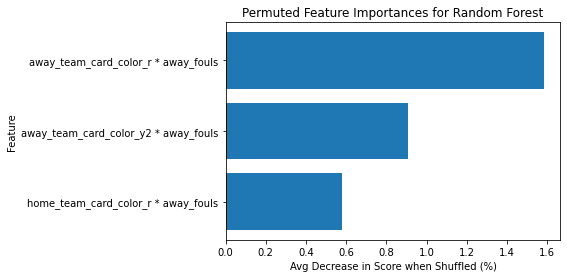

In [555]:
feat_names = np.array(list(map(lambda x: x.replace(' ', ' * '), clf['inter'].get_feature_names_out(X.columns))))
plt.barh(feat_names[qual_idx][::-1], r.importances_mean[qual_idx][::-1]*100)
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg Decrease in Score when Shuffled (%)')
plt.ylabel('Feature')
plt.show()

In [531]:
# 129, 165, 184, 305
for i in tqdm(range(200, 400)):
    np.random.seed(i)
    X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W', 'L'], weight = True, down_sample = True)
    X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)

    clf = RFinterpipe(weights = weights).fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if score > 0.79:
        print('Seed: ', i, score)

  0%|          | 0/200 [00:00<?, ?it/s]

Seed:  305 0.7994011976047904


In [572]:
grid = {
    'logit__C' : [0.5, 1, 2, 5, 10, 15, 20],
    'logit__multi_class' : ['multinomial']
}
X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W', 'L'], weight = True, down_sample = True)
cv = GridSearchCV(Logitpipe(weights), grid, cv = 10, n_jobs = -1).fit(X_ds, y_ds)
cv_res = pd.DataFrame(cv.cv_results_)

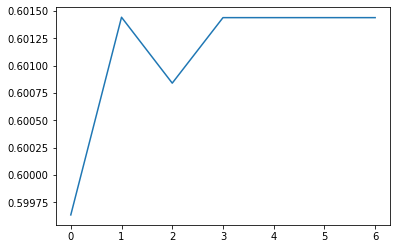

In [575]:
plt.plot(cv_res['mean_test_score'])
plt.show()